# Analysis of Netflix data

Loosely based off of:
https://www.dataquest.io/blog/python-tutorial-analyze-personal-netflix-data/

In [2]:
#pandas import
import pandas as pd
#matplotlib import
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm #for colors
#and numpy
import numpy as np

#disable the warnings for chained data in pandas
pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
#import the data into a pandas dataframe

df = pd.read_csv("../../netflix-report/CONTENT_INTERACTION/ViewingActivity.csv")
#df.head()

In [4]:
#drop those columns that we don't need
df.drop(['Attributes', 'Supplemental Video Type','Device Type', 'Bookmark', 'Latest Bookmark', 'Country'],axis=1)

,Profile Name,Start Time,Duration,Title
0,Bryan,2024-10-05 06:03:04,00:50:54,Monsters: The Lyle and Erik Menendez Story: Ha...
1,Bryan,2024-10-05 06:01:26,00:00:04,2 Guns
2,Bryan,2024-10-04 03:29:01,00:00:06,The Haunting of Hill House: Season 1: The Bent...
3,Bryan,2024-10-04 03:28:41,00:00:01,Chilling Adventures of Sabrina: Part 1: Chapte...
4,Bryan,2024-10-02 05:00:12,00:00:04,Monsters: The Lyle and Erik Menendez Story: Ha...
...,...,...,...,...
32958,s,2014-07-13 20:06:28,00:11:57,Cloudy with a Chance of Meatballs 2
32959,s,2014-05-08 04:05:27,00:47:14,Holes
32960,s,2014-05-08 02:53:05,01:03:49,Holes
32961,s,2013-04-29 04:29:02,00:30:51,Atlantis: The Lost Empire


In [5]:
#now select out only daniel's shows
mask = df['Profile Name'].isin(['daniel'])
#apply mask to select only daniel things
new_df = df[mask]

In [6]:
#check that we are selecting correctly
#drop the columns we don't care about again
simple_df = new_df.drop(['Profile Name','Attributes', 'Supplemental Video Type','Device Type', 'Bookmark', 'Latest Bookmark', 'Country'],axis=1)


In [7]:
#check types of these
simple_df.dtypes

Start Time    object
Duration      object
Title         object
dtype: object

In [8]:
#we need to conver the data types to the correct values
simple_df['Duration'] = pd.to_timedelta(simple_df['Duration'])
simple_df['Start Time'] = pd.to_datetime(simple_df['Start Time'],utc=True)
#convert from UTC to Pacific time
simple_df = simple_df.set_index('Start Time')
simple_df.index = simple_df.index.tz_convert('US/Pacific')
simple_df = simple_df.reset_index()

In [9]:
simple_df.dtypes

Start Time    datetime64[ns, US/Pacific]
Duration                 timedelta64[ns]
Title                             object
dtype: object

In [10]:
#function to act on the data frame and give information on each show
def simple_show_info(show_name):
    show = simple_df[simple_df['Title'].str.contains(f"{show_name}",regex=False)]
    
    
    
    #print(f"Total time spent watching show {show_name}: {show['Duration'].sum()}")

    return show

In [11]:
the_office = simple_show_info('The Office (U.S.)')
the_office.head(10)

,Start Time,Duration,Title
0,2024-10-07 20:17:18-07:00,0 days 00:06:02,The Office (U.S.): Season 7: The Search (Episo...
1,2024-10-07 19:33:07-07:00,0 days 00:15:27,The Office (U.S.): Season 7: The Search (Episo...
2,2024-10-07 19:00:15-07:00,0 days 00:21:38,The Office (U.S.): Season 7: The Seminar (Epis...
3,2024-10-07 18:50:02-07:00,0 days 00:11:45,The Office (U.S.): Season 7: Ultimatum (Episod...
7,2024-10-04 18:35:13-07:00,0 days 00:09:51,The Office (U.S.): Season 7: Ultimatum (Episod...
8,2024-10-04 18:05:57-07:00,0 days 00:20:30,The Office (U.S.): Season 7: Classy Christmas:...
9,2024-10-04 17:39:07-07:00,0 days 00:21:44,The Office (U.S.): Season 7: Classy Christmas:...
10,2024-10-03 12:47:15-07:00,0 days 00:21:38,The Office (U.S.): Season 7: China (Episode 10)
11,2024-10-02 18:19:22-07:00,0 days 00:21:20,The Office (U.S.): Season 7: WUPHF.com (Episod...
12,2024-10-02 17:59:13-07:00,0 days 00:21:35,The Office (U.S.): Season 7: Viewing Party (Ep...


In [12]:
#now try to get all possible tv shows that I have watched

#first we get our titles only
title_df = simple_df['Title']
#show_df = title_df.str.split(": Se")
show_df = title_df.str.split(":")
#show_df = show_df.iloc(0)


In [13]:
#convert these into a set
show_titles = [show_df[i][0] for i in range(show_df.size)]

In [14]:
#check them
show_titles = set(show_titles)

In [15]:
#some have a weird "_ABCD" addition to it. We will get rid of those now and just take above the first "_"

#we also have a bunch of "Season X ABC". We can get rid of those without replacing them
#and some are just trailers. Get rid of those too. 

#These will keep track of the good and bad titles
good_titles = []
bad_titles = []

for title in show_titles:
    if "_" in title:
        main_title = title.split("_")[0]
        good_titles.append(main_title)
        bad_titles.append(title)
    #check for the "Season X" names. Just remove them
    if "season" in title.lower():
        bad_titles.append(title)
    #remove any of those that contain "trailer" except for Trailer Park Boys
    if "trailer" in title.lower() and "trailer park boys" not in title.lower():
        bad_titles.append(title)

#now that we are done, we can add and remove the titles from the set
show_titles.update(good_titles)
show_titles.difference_update(bad_titles)

In [16]:
#check them now
show_titles

{'100',
 '14 Peaks',
 '2012',
 '30 Rock',
 '30 for 30',
 'A Series of Unfortunate Events',
 'A.N.T. Farm',
 'AIB Hook 1',
 'AJIN',
 'About Time',
 'Alice in Borderland',
 'All Hail King Julien',
 'American Horror Story',
 'American Vandal',
 'An American Tail',
 'An Extremely Goofy Movie',
 'Anchorman',
 'Animal Mechanicals',
 'Antz',
 'Apollo 13',
 'Archer',
 'Arrested Development',
 'Arrow',
 'Atlantis',
 'Attack on Titan',
 'Avatar',
 'Avengers',
 'Baby Genius',
 'Band of Brothers',
 'Barbie Life in the Dreamhouse',
 'Barney',
 'Batman Begins',
 'Beavis and Butt-head Do America',
 'Believe in the Stars',
 'Better Call Saul',
 'Between',
 'Beyond Stranger Things',
 'Big Mouth',
 'Big Time Caillou & Other Stories',
 'BigMouth',
 'Blue Mountain State',
 'BoJack Horseman',
 'Bob the Builder',
 'Bob the Builder on Site',
 "Bob's Burgers",
 'Breaking Bad',
 'Brooklyn Nine-Nine',
 'Brother Bear',
 'Brother Bear 2',
 'Buried',
 'Busytown Mysteries',
 'Caillou Cares & Other Stories',
 'Capta

In [17]:
#take a look at everything we have seen
#for title in show_titles:
#    simple_show_info(title)

In [18]:
scrubs = simple_show_info("Scrubs")


In [19]:
#define a function to get the total time spent watching a show in hours

def get_watched_time_hours(dataset):
    return dataset['Duration'].sum() / np.timedelta64(1,'h')

#test it
shows_with_10_days = []
for title in show_titles:
    time_watched = get_watched_time_hours(simple_show_info(title))
    if 240 < time_watched:
        print(f"{title} has {time_watched} hours of watching")
        shows_with_10_days.append(title)

Modern Family has 395.6738888888889 hours of watching
How I Met Your Mother has 1292.7697222222223 hours of watching
The League has 694.9344444444445 hours of watching
House of Cards has 289.3255555555556 hours of watching
Peaky Blinders has 280.26972222222224 hours of watching
The Office (U.S.) has 1879.1144444444444 hours of watching
Parks and Recreation has 760.7061111111111 hours of watching
Scrubs has 457.3713888888889 hours of watching


In [20]:
#define a function to plot what days we watch everything

def watched_which_days(my_show_title):
    #get our show
    my_show = simple_show_info(my_show_title)
    #my_show.head(5)

    #sort it to which days
    my_show['weekday'] = my_show['Start Time'].dt.weekday
    #my_show['hour'] = my_show['Start Time'].dt.hour
    pd.Categorical(my_show['weekday'],categories=[0,1,2,3,4,5,6],ordered=True)
    #show_daily = my_show['weekday'].value_counts()
    #convert to hours watched
    show_daily = my_show.groupby('weekday')['Duration'].sum()/np.timedelta64(1,'h')
    show_daily = show_daily.sort_index()


    #make the plot now
    fig = plt.figure()
    show_daily.plot(kind='bar',title=f'{my_show_title} hours per weekday')

    #axis options
    weekday_axis = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
    y_pos = np.arange(len(weekday_axis))
    plt.xticks(y_pos,weekday_axis)
    plt.ylabel('Hours')
    #plt.show
    
    return fig

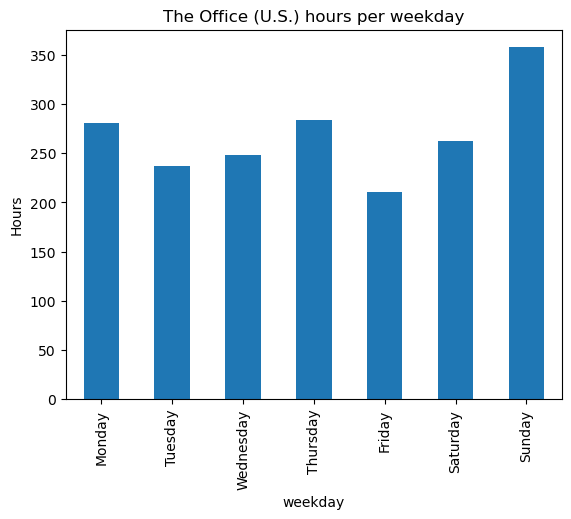

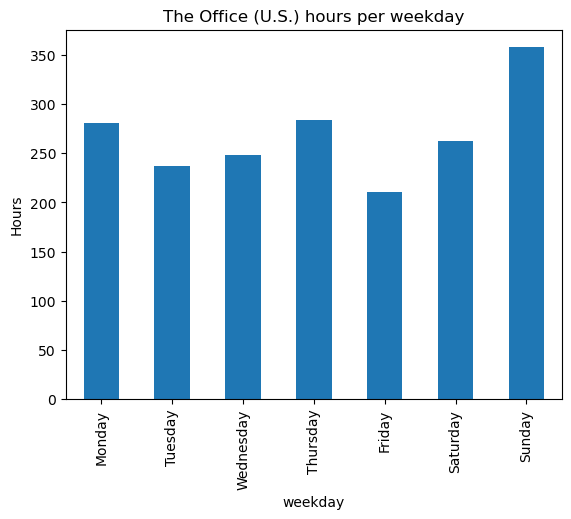

In [21]:
watched_which_days("The Office (U.S.)")

In [22]:
#define a function to plot what hours we watch everything

def watched_which_hours(my_show_title):
    #get our show
    my_show = simple_show_info(my_show_title)
    #my_show.head(5)

    #sort it to which days
    my_show['hour'] = my_show['Start Time'].dt.hour
    pd.Categorical(my_show['hour'],categories=range(0,24),ordered=True)
    #show_hourly = my_show['hour'].value_counts()
    #convert to hours watched
    show_hourly = my_show.groupby('hour')['Duration'].sum()/np.timedelta64(1,'h')
    show_hourly = show_hourly.sort_index()


    #make the plot now
    fig = plt.figure()
    show_hourly.plot(kind='bar',title=f'{my_show_title} hours per time of day',figsize=(12,10))

    #axis options
    #weekday_axis = 
    #y_pos = np.arange(len(weekday_axis))
    #plt.xticks(y_pos,weekday_axis)
    plt.ylabel('Hours')
    plt.xlabel("Time of Day")
    #plt.show
    
    return fig

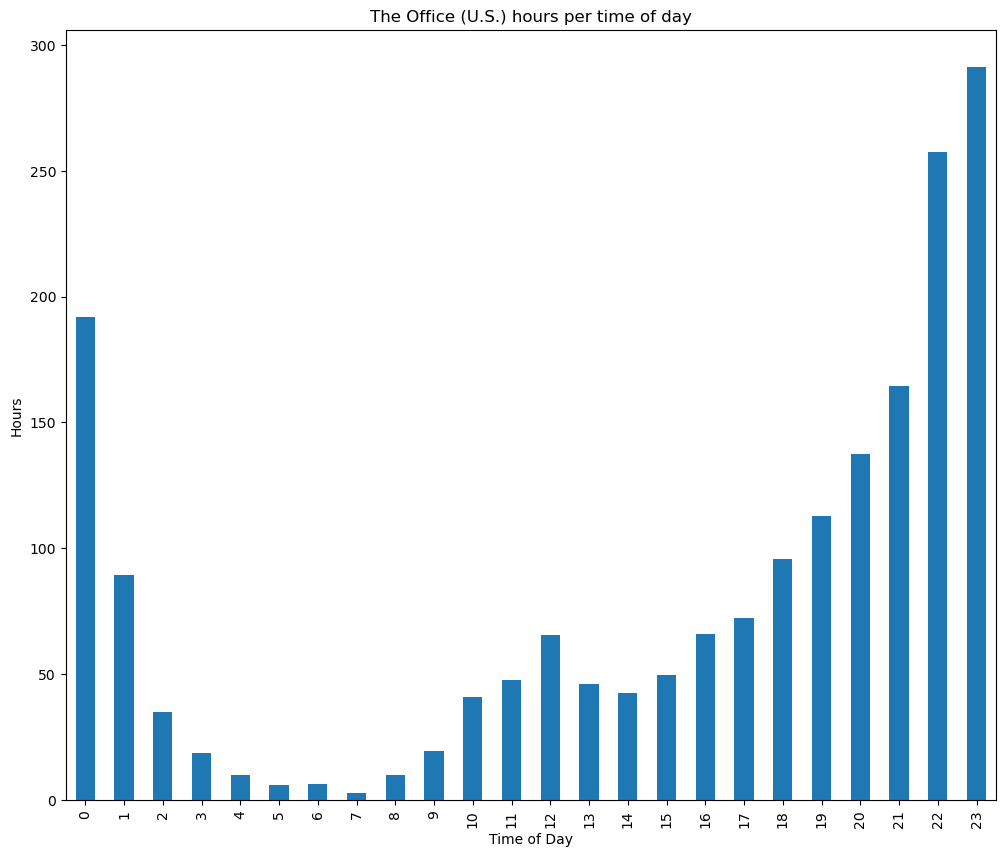

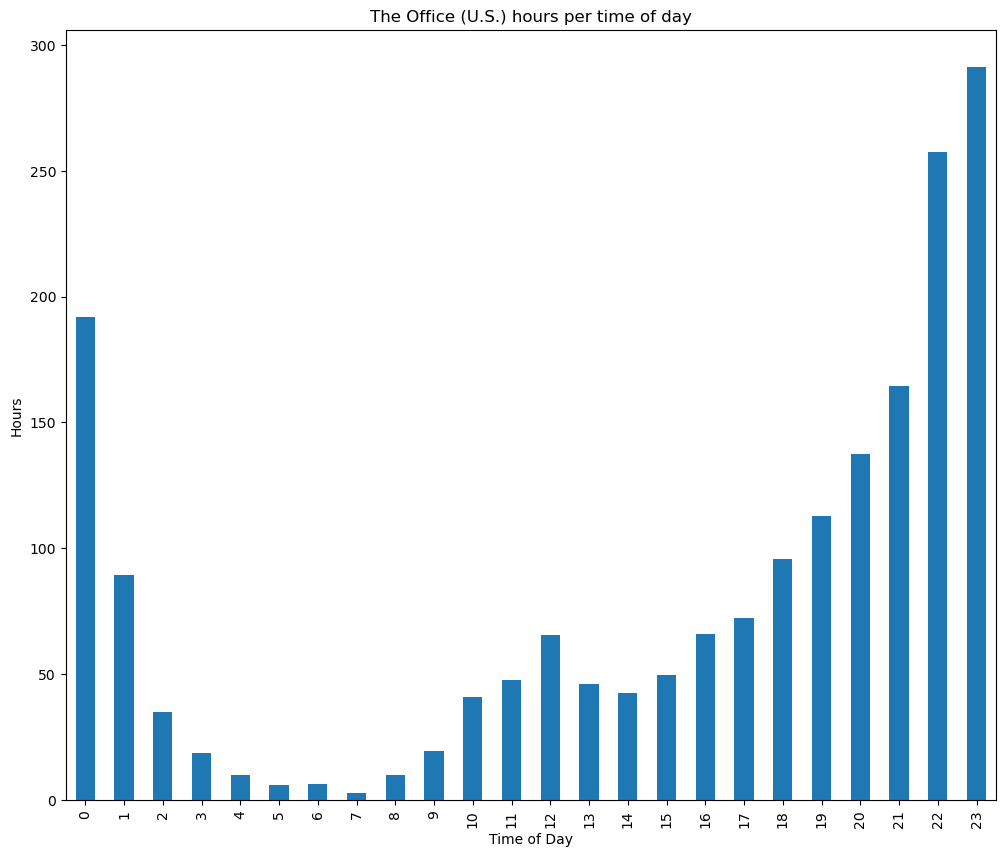

In [23]:
watched_which_hours("The Office (U.S.)")

In [24]:
#define a function to plot what months we watch everything

def watched_which_months(my_show_title):
    #get our show
    my_show = simple_show_info(my_show_title)
    #my_show.head(5)

    #sort it to which days
    my_show['month'] = my_show['Start Time'].dt.month
    pd.Categorical(my_show['month'],categories=range(0,12),ordered=True)
    #show_monthly = my_show['month'].value_counts()
    #convert to hours watched
    show_monthly = my_show.groupby('month')['Duration'].sum()/np.timedelta64(1,'h')
    show_monthly = show_monthly.sort_index()


    #make the plot now
    fig = plt.figure()
    show_monthly.plot(kind='bar',title=f'{my_show_title} hours per month',figsize=(12,5))

    #axis options
    month_axis = ("January","February","March","April","May","June","July","August","September","October","November","December")
    y_pos = np.arange(len(month_axis))
    plt.xticks(y_pos,month_axis)
    plt.ylabel('Hours')
    #plt.show
    
    return fig

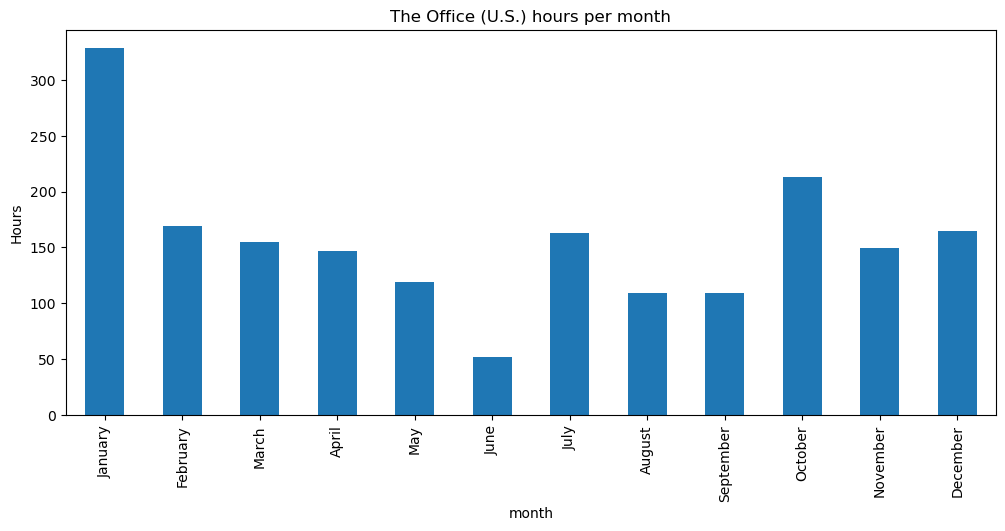

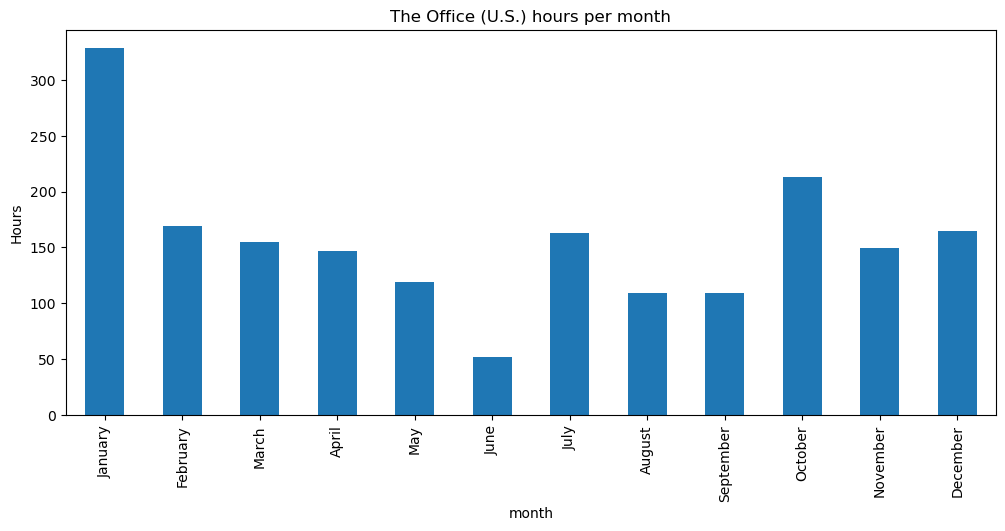

In [25]:
watched_which_months("The Office (U.S.)")

In [26]:
#define a function to plot what years we watch everything

def watched_which_years(my_show_title):
    #get our show
    my_show = simple_show_info(my_show_title)
    #my_show.head(5)

    #sort it to which days
    my_show['year'] = my_show['Start Time'].dt.year
    pd.Categorical(my_show['year'],categories=range(2013,2025),ordered=True)
    #show_yearly = my_show['year'].value_counts()
    #convert to hours watched
    show_yearly = my_show.groupby('year')['Duration'].sum()/np.timedelta64(1,'h')
    show_yearly = show_yearly.sort_index()


    #make the plot now
    fig = plt.figure()
    show_yearly.plot(kind='bar',title=f'{my_show_title} hours per year',figsize=(12,5))

    #axis options
    #year_axis = ("January","February","March","April","May","June","July","August","September","October","November","December")
    #y_pos = np.arange(len(month_axis))
    #plt.xticks(y_pos,month_axis)
    plt.ylabel('Hours')
    #plt.show
    
    return fig

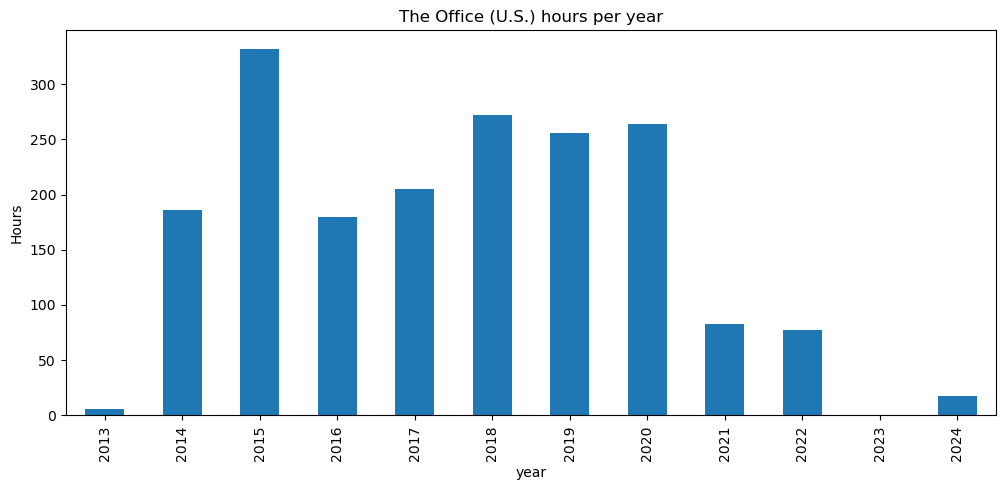

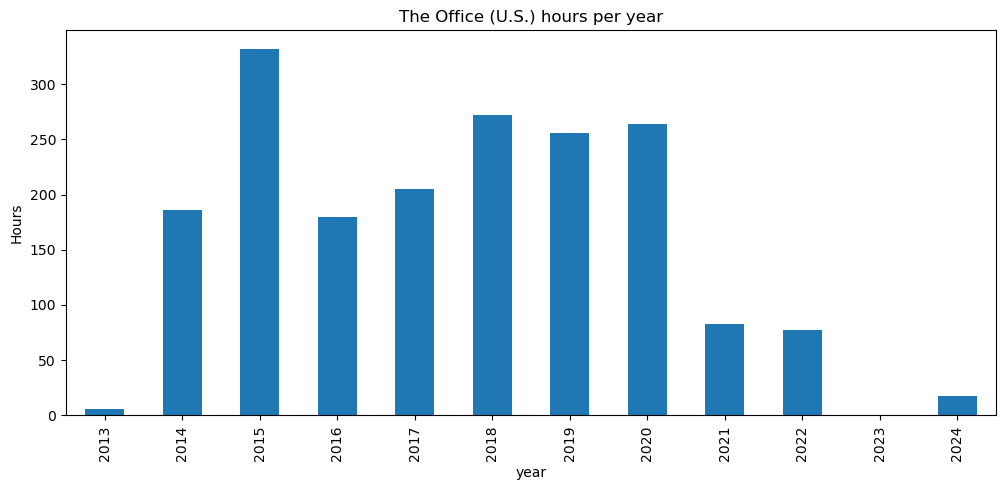

In [27]:
watched_which_years("The Office (U.S.)")

In [110]:
#define a function to plot what years we watch everything
#this one will also take in an axes arguement to plot things overlaid

def watched_which_years_overlaid(my_show_title,ax_all,color):
    #get our show
    my_show = simple_show_info(my_show_title)
    #my_show.head(5)

    #sort it to which days
    my_show['year'] = my_show['Start Time'].dt.year
    pd.Categorical(my_show['year'],categories=range(2013,2025),ordered=True)
    #show_yearly = my_show['year'].value_counts()
    #convert to hours watched
    show_yearly = my_show.groupby('year')['Duration'].sum()/np.timedelta64(1,'h')
    show_yearly = show_yearly.sort_index()


    #Plot it on the overall plot
    show_yearly.plot(style=".-",markersize=12,title=f'{my_show_title} hours per year',figsize=(12,5),ax=ax_all,color=color,label=my_show_title)
    '''
    #make the plot now
    #fig = plt.figure()
    fig,ax = plt.subplots()
    myplot = show_yearly.plot(style=".",title=f'{my_show_title} hours per year',figsize=(12,5),ax=ax)

    #axis options
    year_axis = range(2013,2025)
    y_pos = np.arange(len(year_axis))
    plt.xticks(y_pos,year_axis)
    plt.ylabel('Hours')
    #plt.show
    
    return myplot
    '''

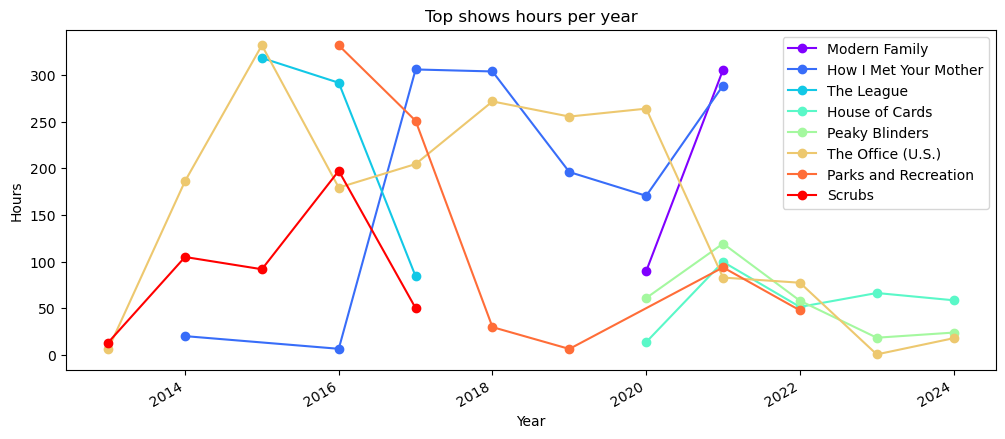

In [112]:
#plot our top shows on the same plot

#create an overall figure and axis for the plot
fig,ax_all = plt.subplots()

#iterate through the colors
color = iter(cm.rainbow(np.linspace(0, 1,len(shows_with_10_days) )))

for title in shows_with_10_days:
    c = next(color)
    watched_which_years_overlaid(title,ax_all,c)

#watched_which_years("Modern Family",ax_all,'blue')
#watched_which_years("Peaky Blinders",ax_all,'green')
#watched_which_years("The Office (U.S.)",ax_all,'red')

ax_all.set_title("Top shows hours per year")
fig.autofmt_xdate()
plt.ylabel("Hours")
plt.xlabel("Year")
plt.legend(loc="best")
plt.show()


In [131]:
#now look at some shows with other times watched:

#test it
shows_with_3_to_10_days = []
for title in show_titles:
    time_watched = get_watched_time_hours(simple_show_info(title))
    #print(f"{title} has {time_watched} hours of watching")
    if 240 > time_watched and 72 < time_watched:
        #print(f"{title} has {time_watched} hours of watching")
        shows_with_3_to_10_days.append(title)
print(shows_with_3_to_10_days)

['Brooklyn Nine-Nine', 'Big Mouth', 'Breaking Bad', 'Sex Education', 'Star Wars']


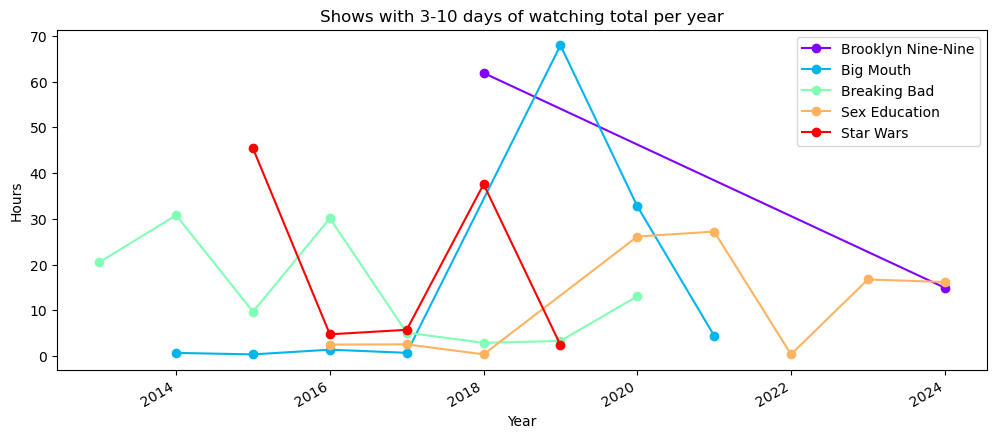

In [132]:
#plot our shows in the 8-10 days watched list on the same plot

#create an overall figure and axis for the plot
fig,ax_all = plt.subplots()

#iterate through the colors
color = iter(cm.rainbow(np.linspace(0, 1,len(shows_with_3_to_10_days) )))

for title in shows_with_3_to_10_days:
    c = next(color)
    watched_which_years_overlaid(title,ax_all,c)

#watched_which_years("Modern Family",ax_all,'blue')
#watched_which_years("Peaky Blinders",ax_all,'green')
#watched_which_years("The Office (U.S.)",ax_all,'red')

ax_all.set_title("Shows with 3-10 days of watching total")
fig.autofmt_xdate()
plt.ylabel("Hours")
plt.xlabel("Year")
plt.legend(loc="best")
plt.show()